In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

import mitosheet

In [3]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [4]:
results = []

### Unstructured Variance, n_input = 12, n_output = 1

In [5]:
df = pd.read_excel("Data/US12I1O.xlsx", index_col = 0)
df

,Input 01,Input 02,Input 03,Input 04,Input 05,Input 06,Input 07,Input 08,Input 09,Input 10,Input 11,Input 12,Output 01
DMU 0001,288.81,493.46,202.31,356.18,384.45,653.77,129.40,100.28,38.45,306.59,92.41,250.91,250.77
DMU 0002,349.98,420.00,139.32,312.89,543.04,504.54,120.43,177.65,86.96,330.87,79.16,201.81,372.71
DMU 0003,280.78,452.42,127.85,315.42,559.22,466.35,166.57,165.57,81.43,359.75,83.23,246.78,293.40
DMU 0004,405.33,376.32,237.28,451.43,414.19,318.03,187.77,154.65,49.71,316.82,97.74,344.70,462.69
DMU 0005,348.96,426.79,170.01,292.91,502.76,342.94,146.53,165.78,63.80,329.79,76.17,355.61,374.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
DMU 0996,206.54,333.40,274.01,424.09,465.99,548.04,143.02,58.25,49.65,355.16,85.54,238.49,279.23
DMU 0997,328.82,415.09,121.60,268.46,494.32,454.22,150.96,143.44,65.04,374.88,69.81,261.57,344.45
DMU 0998,310.52,565.44,126.06,320.91,463.01,390.07,151.81,202.55,101.67,333.12,87.52,328.13,320.62
DMU 0999,390.34,255.88,209.15,269.76,576.57,261.14,162.39,102.92,66.70,401.16,72.50,318.26,380.24


In [6]:
df_sol = pd.read_excel("US12I1O_gradientboostingregressor_Solution.xlsx", index_col=0)[["Efficiency_Scores"]]
df_sol

,Efficiency_Scores
DMU 0001,0.452396
DMU 0002,0.614890
DMU 0003,0.531879
DMU 0004,0.736800
DMU 0005,0.655633
...,...
DMU 0996,0.602185
DMU 0997,0.625057
DMU 0998,0.561999
DMU 0999,0.678913


In [7]:
import mitosheet
mitosheet.sheet(df_sol, view_df=True)

MitoWidget(analysis_data_json='{"analysisName": "UUID-012c9fc1-547c-4381-a099-91b03340f0cb", "code": {"imports…

In [8]:
df_weights = pd.read_excel("US12I1O_gradientboostingregressor_Solution.xlsx", index_col=0).iloc[:, 1:]
df_weights

,Weight_Input 01,Weight_Input 02,Weight_Input 03,Weight_Input 04,Weight_Input 05,Weight_Input 06,Weight_Input 07,Weight_Input 08,Weight_Input 09,Weight_Input 10,Weight_Input 11,Weight_Input 12,Weight_Output 01
DMU 0001,0.001918,0.000000e+00,0.001054,0.000000e+00,0.000000,0.000000,0.000000e+00,0.001918,0.001054,0.000000,0.000000e+00,0.000000e+00,0.001804
DMU 0002,0.000893,2.083228e-04,0.000893,2.083228e-04,0.000083,0.000208,2.083228e-04,0.000893,0.000208,0.000000,2.083228e-04,2.083228e-04,0.001650
DMU 0003,0.001424,0.000000e+00,0.000860,0.000000e+00,0.000000,0.000584,0.000000e+00,0.001029,0.000584,0.000000,0.000000e+00,0.000000e+00,0.001813
DMU 0004,0.001250,0.000000e+00,0.000714,0.000000e+00,0.000000,0.000559,0.000000e+00,0.000714,0.000714,0.000000,0.000000e+00,0.000000e+00,0.001592
DMU 0005,0.001225,0.000000e+00,0.000757,0.000000e+00,0.000000,0.000570,5.701252e-04,0.000757,0.000614,0.000000,0.000000e+00,0.000000e+00,0.001752
...,...,...,...,...,...,...,...,...,...,...,...,...,...
DMU 0996,0.002022,1.210457e-04,0.000598,1.210457e-04,0.000121,0.000121,1.210457e-04,0.002022,0.000598,0.000000,1.210457e-04,1.210457e-04,0.002157
DMU 0997,0.000963,4.821360e-05,0.000963,3.277403e-04,0.000048,0.000328,3.277403e-04,0.000963,0.000963,0.000000,3.277403e-04,4.821360e-05,0.001815
DMU 0998,0.001223,0.000000e+00,0.000760,0.000000e+00,0.000000,0.000576,5.757285e-04,0.000760,0.000576,0.000000,0.000000e+00,0.000000e+00,0.001753
DMU 0999,0.000970,7.311812e-07,0.000970,7.311812e-07,0.000000,0.000970,7.311812e-07,0.000970,0.000970,0.000000,7.311812e-07,7.311812e-07,0.001785


In [9]:
df_zero =(df_weights==0).sum()
df_zero

Weight_Input 01       0
Weight_Input 02     532
Weight_Input 03       1
Weight_Input 04     319
Weight_Input 05     757
Weight_Input 06      42
Weight_Input 07     200
Weight_Input 08       1
Weight_Input 09      12
Weight_Input 10     865
Weight_Input 11     401
Weight_Input 12     635
Weight_Output 01      0
dtype: int64

### ML

In [10]:
X = df
X.head()

,Input 01,Input 02,Input 03,Input 04,Input 05,Input 06,Input 07,Input 08,Input 09,Input 10,Input 11,Input 12,Output 01
DMU 0001,288.81,493.46,202.31,356.18,384.45,653.77,129.40,100.28,38.45,306.59,92.41,250.91,250.77
DMU 0002,349.98,420.00,139.32,312.89,543.04,504.54,120.43,177.65,86.96,330.87,79.16,201.81,372.71
DMU 0003,280.78,452.42,127.85,315.42,559.22,466.35,166.57,165.57,81.43,359.75,83.23,246.78,293.40
DMU 0004,405.33,376.32,237.28,451.43,414.19,318.03,187.77,154.65,49.71,316.82,97.74,344.70,462.69
DMU 0005,348.96,426.79,170.01,292.91,502.76,342.94,146.53,165.78,63.80,329.79,76.17,355.61,374.18


In [11]:
y = df_sol
y.head()

,Efficiency_Scores
DMU 0001,0.452396
DMU 0002,0.614890
DMU 0003,0.531879
DMU 0004,0.736800
DMU 0005,0.655633


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [14]:
dt_model = DecisionTreeRegressor(random_state=42)

pipe_dt = make_pipeline(std_scaler, dt_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_dt, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.002563532599964985
neg_root_mean_squared_error: -0.05059895711872329
r2: 0.7843047775154834


In [15]:
# specify parameter values to search
params = {}
params['decisiontreeregressor__max_depth'] = list(range(1, 15))
params['decisiontreeregressor__min_samples_split'] = list(range(10, 60, 10))
params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]

In [16]:
grid = GridSearchCV(pipe_dt, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'decisiontreeregressor__max_depth': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                              12, 13, 14],
                         'decisiontreeregressor__max_features': ['auto', 'log2',
                                                                 'sqrt', None],
                         'decisiontreeregressor__min_samples_split': [10, 20,
                                                                      30, 40,
                                                                      50]},
             scoring='neg_root_mean_squared_error')

In [17]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y, scoring="r2").mean())

-0.04945295438208689
{'decisiontreeregressor__max_depth': 12, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 10}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=12, max_features='auto',
                                       min_samples_split=10,
                                       random_state=42))])
r2: 0.7937052338784695


In [24]:
imp_dt = grid.best_estimator_.steps[1][1].feature_importances_
imp_dt

array([0.09, 0.  , 0.01, 0.01, 0.01, 0.03, 0.  , 0.02, 0.01, 0.  , 0.  , 0.01, 0.8 ])

In [25]:
#pipe_dt.fit(X, y)
#
#imp_dt = pipe_dt.steps[1][1].feature_importances_
#imp_dt

In [26]:
df_dt = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_dt}).sort_values("Importance", ascending=False)
df_dt

,Feature Name,Importance
12,Output 01,0.803893
0,Input 01,0.085256
5,Input 06,0.029311
7,Input 08,0.021320
11,Input 12,0.013980
...,...,...
4,Input 05,0.007821
9,Input 10,0.003398
10,Input 11,0.003263
1,Input 02,0.002668


In [27]:
input_imp = list(df_dt.loc[df_dt["Feature Name"].str.contains("Input"), "Feature Name"].values)
results.append((grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y, scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

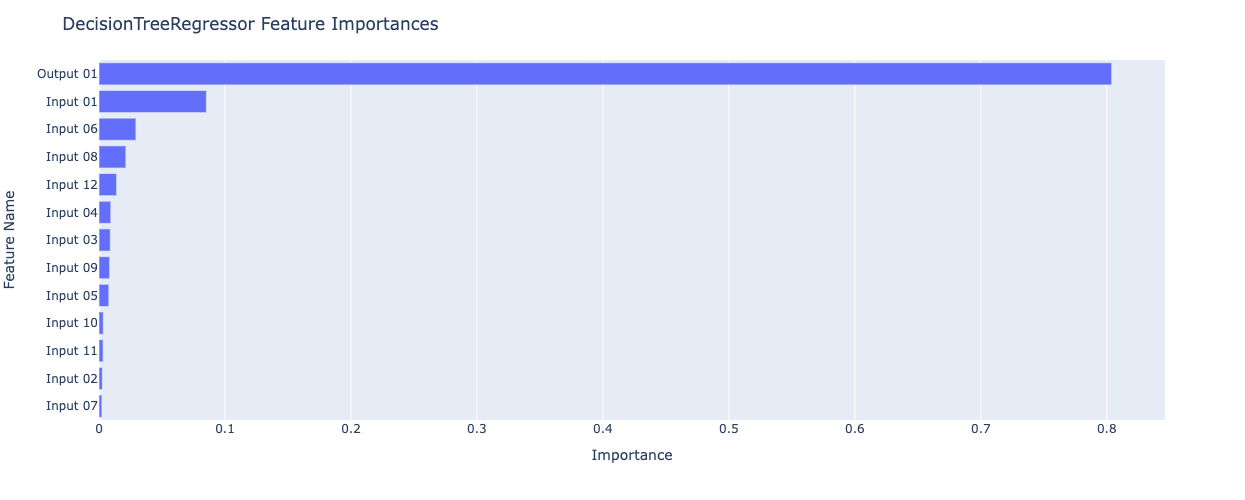

In [28]:
fig = px.bar(df_dt, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"DecisionTreeRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [29]:
df_zero.index = [f.split("_")[1] for f in df_zero.index]

In [30]:
df_merged = pd.merge(df_dt, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Output 01,0.803893,Output 01,0
1,Input 01,0.085256,Input 01,0
2,Input 06,0.029311,Input 06,42
3,Input 08,0.021320,Input 08,1
4,Input 12,0.013980,Input 12,635
...,...,...,...,...
8,Input 05,0.007821,Input 05,757
9,Input 10,0.003398,Input 10,865
10,Input 11,0.003263,Input 11,401
11,Input 02,0.002668,Input 02,532


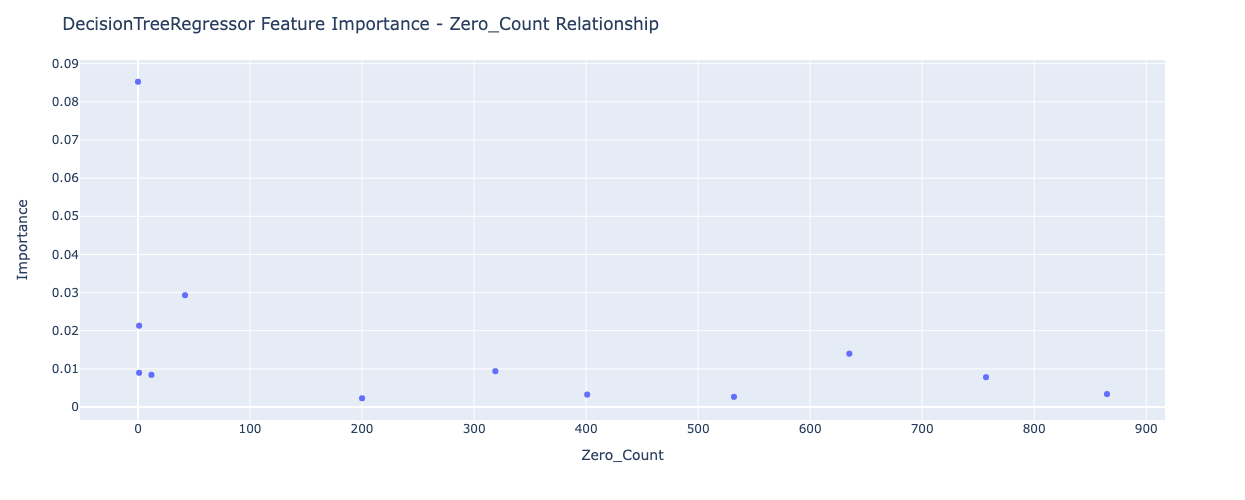

In [31]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"DecisionTreeRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

In [32]:
rf_model = RandomForestRegressor(random_state=42)

pipe_rf = make_pipeline(std_scaler, rf_model)


# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0012720863542704415
neg_root_mean_squared_error: -0.03559888410181345
r2: 0.8925699337553459


In [33]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
print(n_estimators)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
print(max_depth)
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [34]:
# specify parameter values to search
params = {}
params['randomforestregressor__n_estimators'] = n_estimators
params['randomforestregressor__max_features'] = max_features
params['randomforestregressor__max_depth'] = max_depth
params['randomforestregressor__min_samples_split'] = min_samples_split
params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
params['randomforestregressor__bootstrap'] = bootstrap

In [35]:
grid = RandomizedSearchCV(pipe_rf, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'randomforestregressor__bootstrap': [True,
                                                                             False],
                                        'randomforestregressor__max_depth': [10,
                                                                             20,
                                                                             30,
                                                                             40,
                                                                             50,
                                                                             60,
                                

In [36]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.03550829287128186
{'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
                                       n_estimators=800, random_state=42))])
r2: 0.893056358244203


In [37]:
imp_rf = grid.best_estimator_.steps[1][1].feature_importances_
imp_rf

array([0.09, 0.01, 0.01, 0.01, 0.01, 0.03, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.8 ])

In [38]:
#pipe_rf.fit(X, y.values.ravel())
#
#imp_rf = pipe_rf.steps[1][1].feature_importances_

In [39]:
df_rf = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_rf}).sort_values("Importance", ascending=False)
df_rf

,Feature Name,Importance
12,Output 01,0.798558
0,Input 01,0.085404
5,Input 06,0.031068
7,Input 08,0.020511
4,Input 05,0.009888
...,...,...
3,Input 04,0.007088
8,Input 09,0.006287
6,Input 07,0.005569
9,Input 10,0.005492


In [40]:
input_imp = list(df_rf.loc[df_rf["Feature Name"].str.contains("Input"), "Feature Name"].values)
results.append((grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

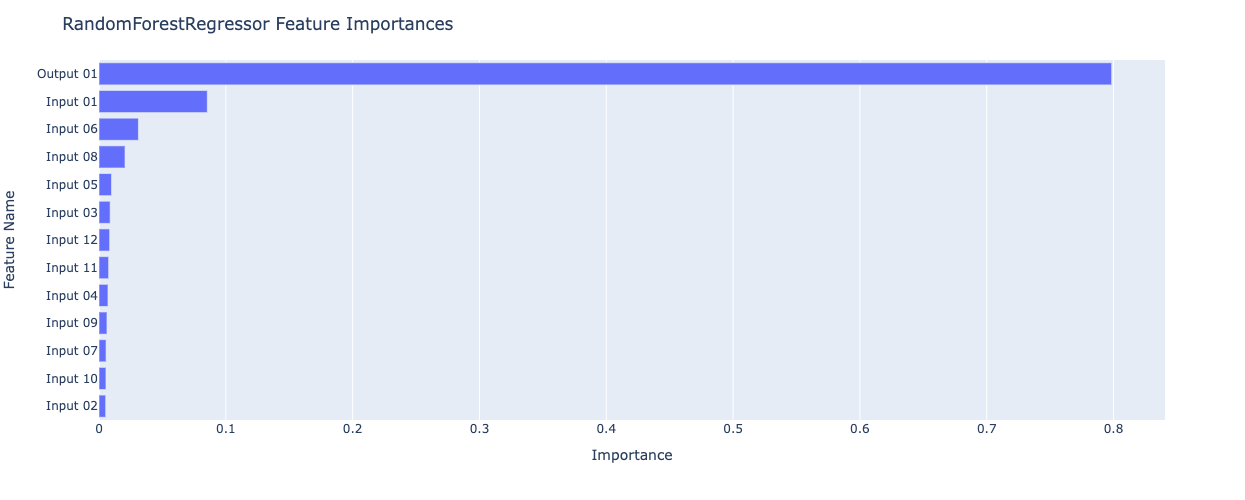

In [41]:
fig = px.bar(df_rf, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"RandomForestRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [42]:
df_merged = pd.merge(df_rf, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Output 01,0.798558,Output 01,0
1,Input 01,0.085404,Input 01,0
2,Input 06,0.031068,Input 06,42
3,Input 08,0.020511,Input 08,1
4,Input 05,0.009888,Input 05,757
...,...,...,...,...
8,Input 04,0.007088,Input 04,319
9,Input 09,0.006287,Input 09,12
10,Input 07,0.005569,Input 07,200
11,Input 10,0.005492,Input 10,865


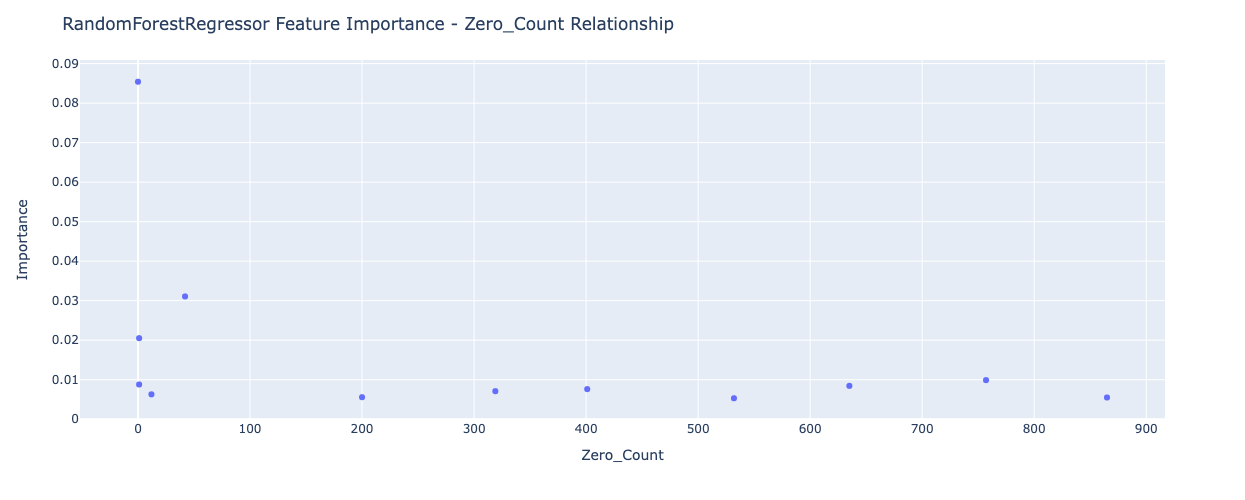

In [43]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"RandomForestRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

In [44]:
gb_model = GradientBoostingRegressor(random_state=42)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0007980124412774086
neg_root_mean_squared_error: -0.028152375480346055
r2: 0.9330223564749056


In [45]:
#learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
#n_estimators = [200, 500, 1000, 2000]
#max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
#print(max_depth)
#max_depth.append(None)
## Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
## Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]

In [46]:
learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

In [47]:
# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

In [48]:
grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(random_state=42))]),
                   param_distributions={'gradientboostingregressor__learning_rate': [1,
                                                                                     0.5,
                                                                                     0.1,
                                                                                     0.01],
                                        'gradientboostingregressor__max_depth': [3,
                                                                                 5,
                                                                                 10,
                                                                 

In [49]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.01896877051970531
{'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, min_samples_leaf=2,
                                           min_samples_split=30,
                                           n_estimators=500, random_state=42,
                                           subsample=0.3))])
r2: 0.96980598298908


In [50]:
imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
imp_gb

array([0.13, 0.01, 0.02, 0.01, 0.01, 0.05, 0.01, 0.04, 0.01, 0.01, 0.01, 0.02, 0.69])

In [51]:
#pip_gb.fit(X, y.values.ravel())
#
#imp_gb = pip_gb.steps[1][1].feature_importances_

In [52]:
df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
df_gb

,Feature Name,Importance
12,Output 01,0.689657
0,Input 01,0.125042
5,Input 06,0.047707
7,Input 08,0.038339
2,Input 03,0.021502
...,...,...
10,Input 11,0.010266
4,Input 05,0.007806
9,Input 10,0.006779
1,Input 02,0.006309


In [53]:
input_imp = list(df_gb.loc[df_gb["Feature Name"].str.contains("Input"), "Feature Name"].values)
results.append((grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

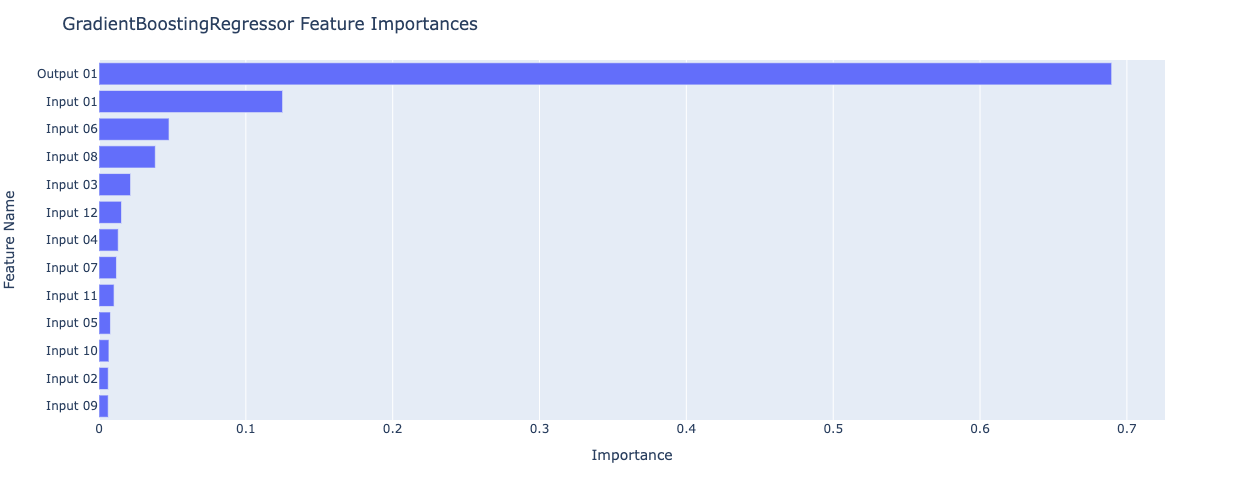

In [54]:
fig = px.bar(df_gb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"GradientBoostingRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [55]:
df_merged = pd.merge(df_gb, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Output 01,0.689657,Output 01,0
1,Input 01,0.125042,Input 01,0
2,Input 06,0.047707,Input 06,42
3,Input 08,0.038339,Input 08,1
4,Input 03,0.021502,Input 03,1
...,...,...,...,...
8,Input 11,0.010266,Input 11,401
9,Input 05,0.007806,Input 05,757
10,Input 10,0.006779,Input 10,865
11,Input 02,0.006309,Input 02,532


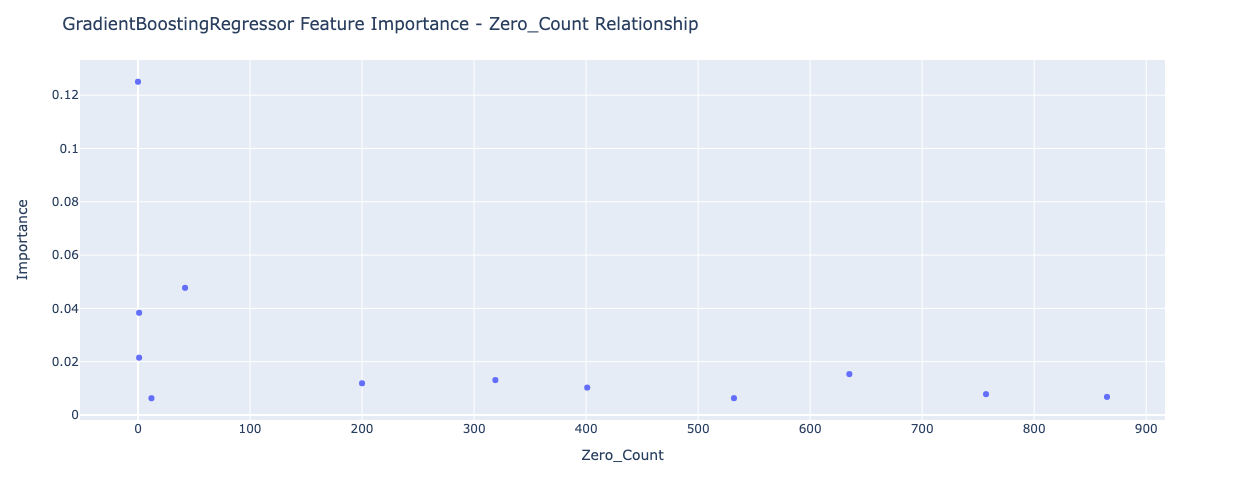

In [56]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"GradientBoostingRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

In [57]:
model = grid.best_estimator_.fit(X_train, y_train.values.ravel())
prediction = model.predict(X_test)

In [58]:
res = pd.DataFrame()
res["Prediction"] = pd.Series(prediction.ravel())
res["Actual"] = y_test.values
res["Diff"] = res.Prediction - res.Actual
res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Perc < 3"] = np.abs(res["Error_Perc"]) < 3  
res = res.round(4)
res.index = X_test.index
res

,Prediction,Actual,Diff,Error_Perc,Error_Perc < 3
DMU 0522,0.6072,0.6362,-0.0290,-4.5635,False
DMU 0738,0.6458,0.6370,0.0088,1.3759,True
DMU 0741,0.8115,0.8033,0.0082,1.0238,True
DMU 0661,0.8269,0.8267,0.0002,0.0247,True
DMU 0412,0.7801,0.7673,0.0128,1.6725,True
...,...,...,...,...,...
DMU 0409,0.7618,0.7345,0.0273,3.7157,False
DMU 0333,0.8097,0.8089,0.0008,0.1030,True
DMU 0209,0.7973,0.7929,0.0043,0.5474,True
DMU 0614,0.8218,0.8652,-0.0434,-5.0139,False


In [59]:
blue = res["Error_Perc < 3"].sum()
print(blue)
red = len(res["Error_Perc < 3"]) - (res["Error_Perc < 3"].sum())
red

155


45

In [60]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9835
p-Value 0.0


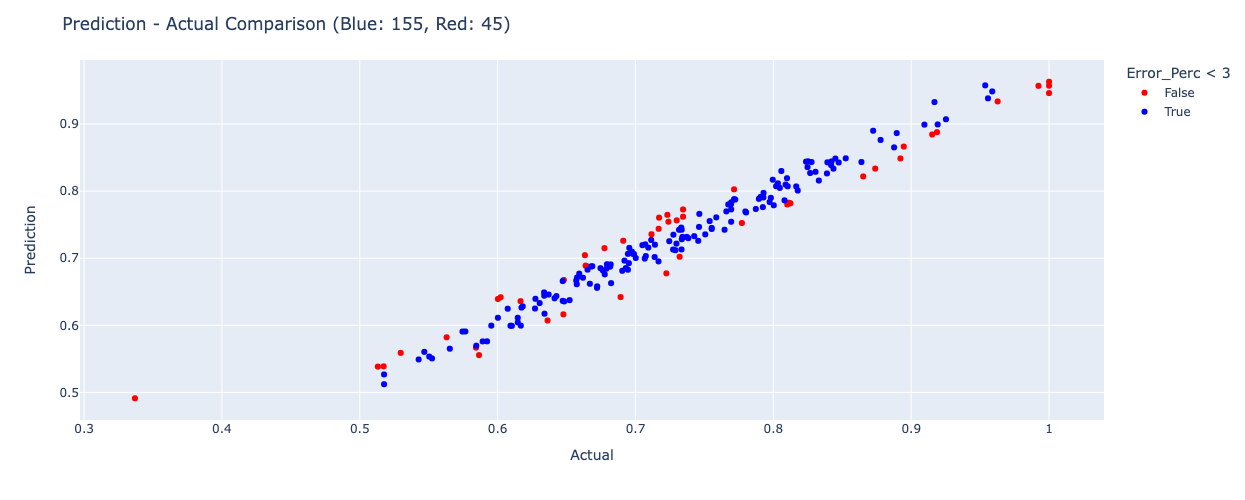

In [61]:
fig = px.scatter(res.reset_index().rename(columns={'index': 'DMU'}), x="Actual", y="Prediction", color = "Error_Perc < 3", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Perc", "DMU"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

In [62]:
xgb_model = xgb.XGBRegressor(random_state=42)

pipe_xgb = make_pipeline(std_scaler, xgb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0009786101815708408
neg_root_mean_squared_error: -0.031234553177500186
r2: 0.917412859119534


In [63]:
# xgb.plot_tree(xgb_model,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.show()

In [64]:
learning_rate = [0.01, 0.1, 0.2, 0.3]
n_estimators = [100, 500, 1000]
max_depth =  [3, 5, 6, 10, 15, 20]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)

In [65]:
# specify parameter values to search
params = {}
params['xgbregressor__learning_rate'] = learning_rate
params['xgbregressor__n_estimators'] = n_estimators
params['xgbregressor__max_depth'] = max_depth
params['xgbregressor__subsample'] = subsample
params['xgbregressor__colsample_bytree'] = colsample_bytree
params['xgbregressor__colsample_bylevel'] = colsample_bylevel

In [66]:
grid = RandomizedSearchCV(pipe_xgb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           enable_categorical=False,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type=None,
                                                           interaction_constrai

In [67]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.032065193953831186
{'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__colsample_bylevel': 0.7999999999999999}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.7999999999999999,
                              colsample_bynode=1, colsample_bytree=0.7,
                              enable_categorical=False, gamma=0, gpu_id=-1,
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_delta_step=0, max_depth=6,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=500,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
      

In [68]:
imp_xgb = grid.best_estimator_.steps[1][1].feature_importances_
imp_xgb

array([0.06, 0.02, 0.02, 0.01, 0.02, 0.04, 0.02, 0.04, 0.02, 0.04, 0.02, 0.02, 0.68], dtype=float32)

In [69]:
df_xgb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_xgb}).sort_values("Importance", ascending=False)
df_xgb

,Feature Name,Importance
12,Output 01,0.675423
0,Input 01,0.058504
5,Input 06,0.040143
7,Input 08,0.039237
9,Input 10,0.038783
...,...,...
8,Input 09,0.018395
4,Input 05,0.018253
10,Input 11,0.016078
2,Input 03,0.015928


In [70]:
input_imp = list(df_xgb.loc[df_xgb["Feature Name"].str.contains("Input"), "Feature Name"].values)
results.append((grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

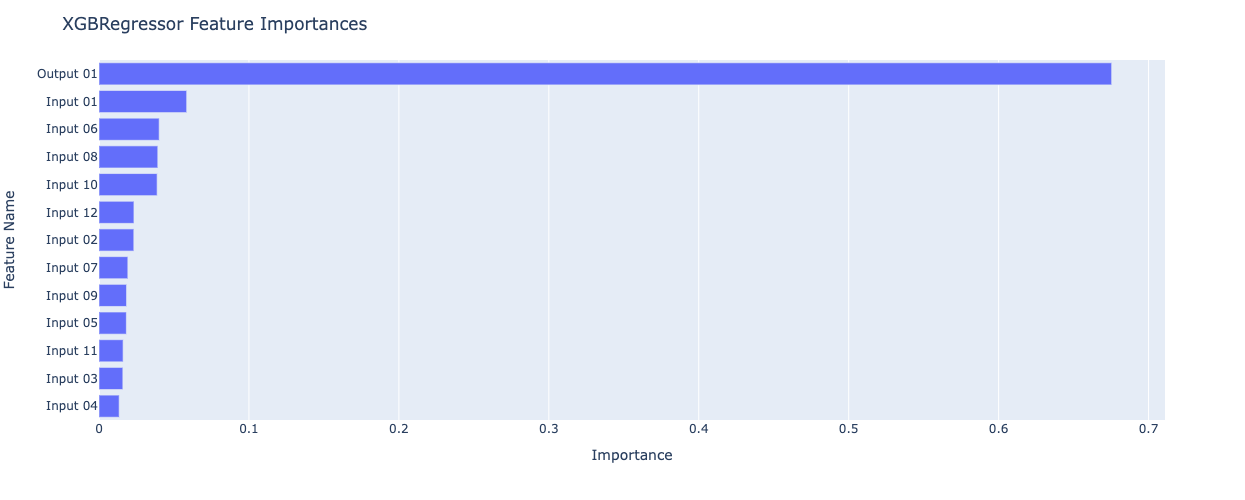

In [71]:
fig = px.bar(df_xgb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"XGBRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [72]:
df_merged = pd.merge(df_xgb, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Output 01,0.675423,Output 01,0
1,Input 01,0.058504,Input 01,0
2,Input 06,0.040143,Input 06,42
3,Input 08,0.039237,Input 08,1
4,Input 10,0.038783,Input 10,865
...,...,...,...,...
8,Input 09,0.018395,Input 09,12
9,Input 05,0.018253,Input 05,757
10,Input 11,0.016078,Input 11,401
11,Input 03,0.015928,Input 03,1


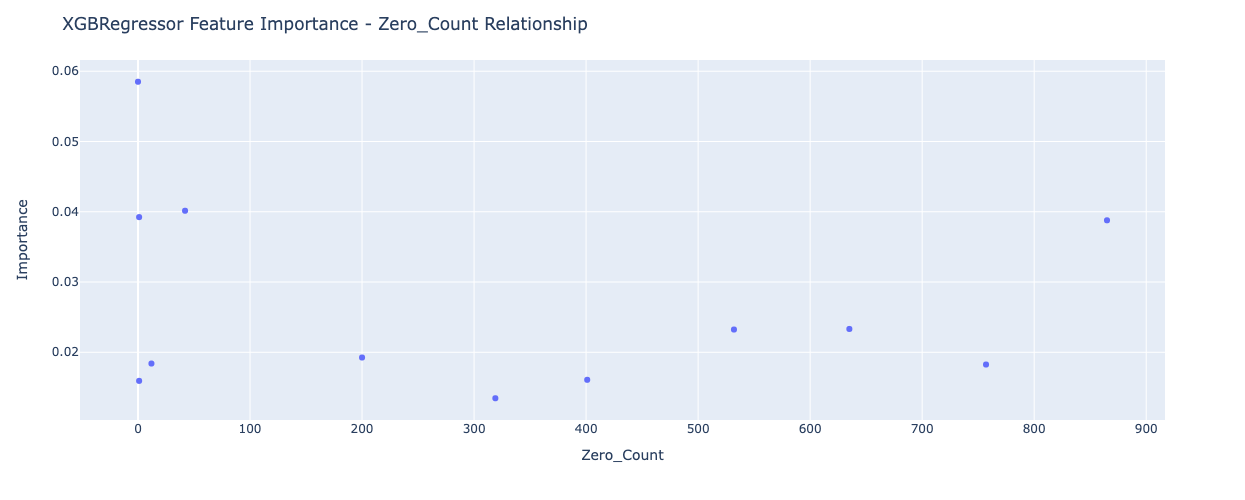

In [73]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"XGBRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

In [74]:
pipe_xgb.fit(X, y.values.ravel())

pipe_xgb.steps[1][1].feature_importances_

array([0.06, 0.  , 0.01, 0.  , 0.01, 0.03, 0.  , 0.03, 0.  , 0.  , 0.01, 0.01, 0.82], dtype=float32)

In [75]:
pipe_xgb.steps[1][1].get_booster().get_score(importance_type='cover')

{'f0': 135.4488067626953,
 'f1': 85.28704071044922,
 'f2': 206.03199768066406,
 'f3': 159.1443328857422,
 'f4': 132.34132385253906,
 'f5': 162.18182373046875,
 'f6': 168.9770050048828,
 'f7': 180.93478393554688,
 'f8': 162.9685516357422,
 'f9': 118.48876190185547,
 'f10': 119.66451263427734,
 'f11': 179.06077575683594,
 'f12': 256.18670654296875}

In [76]:
plt.rcParams['figure.figsize'] = [12, 10]

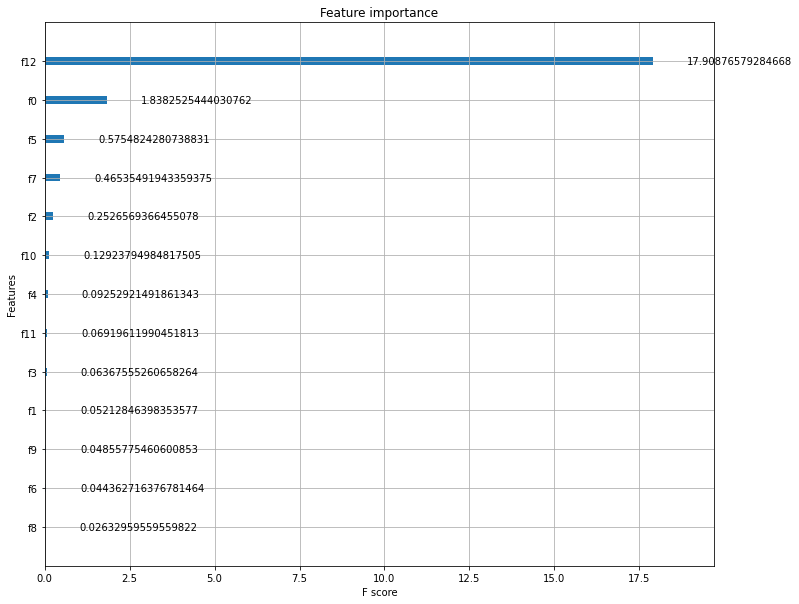

In [77]:
xgb.plot_importance(pipe_xgb.steps[1][1]._Booster, importance_type='total_gain')
plt.show()

In [78]:
results

[('decisiontreeregressor',
  ['Input 01',
   'Input 06',
   'Input 08',
   'Input 12',
   'Input 04',
   'Input 03',
   'Input 09',
   'Input 05',
   'Input 10',
   'Input 11',
   'Input 02',
   'Input 07'],
  {'r2': 0.7937052338784695,
   'neg_root_mean_squared_error': -0.04945295438208689}),
 ('decisiontreeregressor',
  ['Input 01',
   'Input 06',
   'Input 08',
   'Input 12',
   'Input 04',
   'Input 03',
   'Input 09',
   'Input 05',
   'Input 10',
   'Input 11',
   'Input 02',
   'Input 07'],
  {'r2': 0.7937052338784695,
   'neg_root_mean_squared_error': -0.04945295438208689}),
 ('randomforestregressor',
  ['Input 01',
   'Input 06',
   'Input 08',
   'Input 05',
   'Input 03',
   'Input 12',
   'Input 11',
   'Input 04',
   'Input 09',
   'Input 07',
   'Input 10',
   'Input 02'],
  {'r2': 0.893056358244203,
   'neg_root_mean_squared_error': -0.03550829287128186}),
 ('gradientboostingregressor',
  ['Input 01',
   'Input 06',
   'Input 08',
   'Input 03',
   'Input 12',
   'Input 

In [79]:
with open('result_12I1O_2.pkl', 'wb') as f:
    pickle.dump(results, f)

In [80]:
with open('result_12I1O_2.pkl', 'rb') as f:
    r = pickle.load(f)

In [81]:
r

[('decisiontreeregressor',
  ['Input 01',
   'Input 06',
   'Input 08',
   'Input 12',
   'Input 04',
   'Input 03',
   'Input 09',
   'Input 05',
   'Input 10',
   'Input 11',
   'Input 02',
   'Input 07'],
  {'r2': 0.7937052338784695,
   'neg_root_mean_squared_error': -0.04945295438208689}),
 ('decisiontreeregressor',
  ['Input 01',
   'Input 06',
   'Input 08',
   'Input 12',
   'Input 04',
   'Input 03',
   'Input 09',
   'Input 05',
   'Input 10',
   'Input 11',
   'Input 02',
   'Input 07'],
  {'r2': 0.7937052338784695,
   'neg_root_mean_squared_error': -0.04945295438208689}),
 ('randomforestregressor',
  ['Input 01',
   'Input 06',
   'Input 08',
   'Input 05',
   'Input 03',
   'Input 12',
   'Input 11',
   'Input 04',
   'Input 09',
   'Input 07',
   'Input 10',
   'Input 02'],
  {'r2': 0.893056358244203,
   'neg_root_mean_squared_error': -0.03550829287128186}),
 ('gradientboostingregressor',
  ['Input 01',
   'Input 06',
   'Input 08',
   'Input 03',
   'Input 12',
   'Input 

In [82]:
ft_imp  = df_dt.set_index("Feature Name").join(df_rf.set_index("Feature Name"), rsuffix="_rf").join(df_gb.set_index("Feature Name"), rsuffix="_gb").join(df_xgb.set_index("Feature Name"), rsuffix="_xgb")
ft_imp

,Importance,Importance_rf,Importance_gb,Importance_xgb
Feature Name,,,,
Output 01,0.803893,0.798558,0.689657,0.675423
Input 01,0.085256,0.085404,0.125042,0.058504
Input 06,0.029311,0.031068,0.047707,0.040143
Input 08,0.021320,0.020511,0.038339,0.039237
Input 12,0.013980,0.008437,0.015335,0.023316
...,...,...,...,...
Input 05,0.007821,0.009888,0.007806,0.018253
Input 10,0.003398,0.005492,0.006779,0.038783
Input 11,0.003263,0.007616,0.010266,0.016078


In [83]:
ft_imp.to_excel("Data/US12I1O_ft_imp_2.xlsx")